In [14]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))  

In [ ]:
from prompts.promptmanager import PromptManager
from prompts.prompt_type.fairy.FairyPromptType import FairyPromptType
from agents.fairy.util import get_groq_llm_lc
from langchain_core.messages import HumanMessage, SystemMessage
from agents.fairy.fairy_state import FairyDungeonIntentOutput
from enums.LLM import LLM

expect_multi_question = "HP 포션좀 먹고 싶어, 물약좀 먹으면서 저 슬라임 공략법에 대해 알려줘"
expect_monster = "저거 공략법좀 알려줘"
expect_event = "이 석상을 부시면 어떻게 되는거야?"
expect_navigator= "현재 방에서 어디로 가야돼?"
expect_interaction_handler = "방 불좀 켜줘"
expect_small_talk = "심심행"
expect_unknown_intent = "al;sdas 내가 낀 아이템을 사용해"
expect_game_system = "게임 어떻게 꺼?"
expect_super_multi = "내가 낀 아이템을 사용해 그리고 저 몬스터 공략법좀 알려줘 그리고 이 석상을 어떻게 부셔? 다음 던전 방에는 뭐고? 그리고 심심해 그리고 게임 어떻게 종료해?"

system_prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_INTENT).get_prompt()

messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=expect_super_multi)
] 

parser_llm = get_groq_llm_lc(model=LLM.LLAMA_3_1_8B_INSTANT, max_token=43).with_structured_output(FairyDungeonIntentOutput)
result = parser_llm.invoke(messages)
result

# invoke(messages).content


# result.content

/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/pydantic/main.py:250: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


FairyDungeonIntentOutput(intents=[<FairyDungeonIntentType.INTERACTION_HANDLER: 'INTERACTION_HANDLER'>, <FairyDungeonIntentType.MONSTER_GUIDE: 'MONSTER_GUIDE'>, <FairyDungeonIntentType.EVENT_GUIDE: 'EVENT_GUIDE'>, <FairyDungeonIntentType.DUNGEON_NAVIGATOR: 'DUNGEON_NAVIGATOR'>, <FairyDungeonIntentType.SMALLTALK: 'SMALLTALK'>, <FairyDungeonIntentType.GAME_SYSTEM_INFO: 'GAME_SYSTEM_INFO'>])

In [ ]:
# %%writefile fairy_dungeon_agent.py

from agents.fairy.fairy_state import FairyDungeonIntentOutput, FairyDungeonState, FairyDungeonIntentType
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.types import interrupt
from agents.fairy.cache_data import reverse_questions, GAME_SYSTEM_INFO
from prompts.promptmanager import PromptManager
from prompts.prompt_type.fairy.FairyPromptType import FairyPromptType
import random, asyncio
from agents.fairy.util import (
    add_ai_message,
    add_human_message,
    str_to_bool,
    get_small_talk_history,
    get_groq_llm_lc,
)
from core.common import get_inventory_items
from enums.LLM import LLM
from langchain.chat_models import init_chat_model


check_multi_llm = get_groq_llm_lc(model=LLM.LLAMA_3_1_8B_INSTANT, max_token=8)
intent_llm = get_groq_llm_lc(model=LLM.LLAMA_3_1_8B_INSTANT, max_token=43)
action_llm = get_groq_llm_lc()
# small_talk_llm = get_groq_llm_lc(temperature=0.4)
small_talk_llm = init_chat_model(model=LLM.GPT4_1_MINI, temperature=0.4)


async def monster_rag():
    return "asd"

async def get_event_info():
    return "asdasd"

async def dungeon_navigator():
    return "dungeon_navi"


async def create_interaction(inventory_ids):
    #  items_descriptions = []
    #  for item in get_inventory_items(inventory_ids):
    #      items_descriptions.append(item.model_dump_json(indent=2))
    inventory_prompt = f"        <인벤토리 내의 아이템 설명>\n{get_inventory_items(inventory_ids)}\n        </인벤토리 내의 아이템 설명>"

    result = inventory_prompt
    return result

async def get_system_info():
    return GAME_SYSTEM_INFO

async def _clarify_intent(query):
    intent_prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_INTENT).get_prompt()
    messages = [SystemMessage(content=intent_prompt), HumanMessage(content=query)]
    parser_llm = intent_llm.with_structured_output(FairyDungeonIntentOutput)
    intent_output: FairyDungeonIntentOutput = await parser_llm.ainvoke(messages)
    return intent_output


async def check_memory_question(query: str) -> bool:
    prompt = PromptManager(FairyPromptType.QUESTION_HISTORY_CHECK).get_prompt(
        question=query
    )
    reponse = await check_multi_llm.ainvoke(prompt)
    return str_to_bool(reponse.content)
    


async def analyze_intent(state: FairyDungeonState):
    last = state["messages"][-1]
    last_message = last.content
    print("질문",last_message)
    clarify_intent_type, is_question_memory = await asyncio.gather(
        _clarify_intent(last_message), check_memory_question(last_message)
    )
    
    if clarify_intent_type.intents[0] == FairyDungeonIntentType.UNKNOWN_INTENT:
        clarification = reverse_questions[random.randint(0, 49)]
        user_resp = interrupt(clarification)
        return {
            "messages": [
                add_ai_message(
                    content=clarification, intent_types=clarify_intent_type.intents
                ),
                add_human_message(content=user_resp),
            ],
            "intent_types": clarify_intent_type.intents,
            "is_multi_small_talk": False,
        }
    print("의도 포함",FairyDungeonIntentType.SMALLTALK in clarify_intent_type.intents)
    print("체크 메모리",is_question_memory)
    is_multi_small_talk = (
        FairyDungeonIntentType.SMALLTALK in clarify_intent_type.intents
    ) and is_question_memory
    print("멀티턴", is_multi_small_talk)
    return {
        "intent_types": clarify_intent_type.intents,
        "is_multi_small_talk": is_multi_small_talk,
    }


def check_condition(state: FairyDungeonState):
    intent_types = state.get("intent_types", [])
    is_multi_small_talk = state.get("is_multi_small_talk", False)
    if intent_types[0] == FairyDungeonIntentType.UNKNOWN_INTENT:
        return "retry"

    if is_multi_small_talk:
        print("아래의 멀티턴", is_multi_small_talk)
        return "multi_small_talk"

    print("2")
    return "continue"


from agents.fairy.util import get_small_talk_history


def multi_small_talk_node(state: FairyDungeonState):
    intent_types = state.get("intent_types")
    player = state["dungenon_player"]
    histories = get_small_talk_history(state["messages"])
    prompt = PromptManager(FairyPromptType.FAIRY_MULTI_SMALL_TALK).get_prompt(
        location="던전", dungenon_player=player, histories=histories
    )
    question = state["messages"][-1].content
    action_llm.invoke([SystemMessage(content=prompt), HumanMessage(content=question)])

    ai_answer = small_talk_llm.invoke(prompt)
    return {
        "messages": [
            add_ai_message(content=ai_answer.content, intent_types=intent_types)
        ]
    }


async def fairy_action(state: FairyDungeonState):
    intent_types = state.get("intent_types")
    dungenon_player = state["dungenon_player"]
    INTENT_HANDLERS = {
        FairyDungeonIntentType.MONSTER_GUIDE: monster_rag,
        FairyDungeonIntentType.EVENT_GUIDE: get_event_info,
        FairyDungeonIntentType.DUNGEON_NAVIGATOR: dungeon_navigator,
        FairyDungeonIntentType.INTERACTION_HANDLER: lambda: create_interaction(
            dungenon_player.inventory
        ),
        FairyDungeonIntentType.GAME_SYSTEM_INFO: get_system_info
    }

    INTENT_LABELS = {
        FairyDungeonIntentType.MONSTER_GUIDE: "몬스터 공략",
        FairyDungeonIntentType.EVENT_GUIDE: "이벤트",
        FairyDungeonIntentType.DUNGEON_NAVIGATOR: "길안내",
        FairyDungeonIntentType.INTERACTION_HANDLER: "상호작용",
        FairyDungeonIntentType.GAME_SYSTEM_INFO: "게임 시스템 정보"
    }

    handlers = [INTENT_HANDLERS[i]() for i in intent_types if i in INTENT_HANDLERS]
    results = await asyncio.gather(*handlers)

    prompt_info = ""
    idx = 0
    for i, index in enumerate(intent_types):
        handler = INTENT_HANDLERS.get(index)
        if not handler:
            continue

        value = results[idx]
        label = INTENT_LABELS.get(index, "정보")
        if i == 0:
            prompt_info += f"    <{label}>\n{value}\n    </{label}>"
        else:
            prompt_info += f"\n    <{label}>\n{value}\n    </{label}>"
        idx += 1

    pretty_dungenon_player = dungenon_player.model_dump_json(indent=2)
    prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_SYSTEM).get_prompt(
        dungenon_player=pretty_dungenon_player,
        use_intents=[rt.value if hasattr(rt, "value") else rt for rt in intent_types],
        info=prompt_info,
    )

    ai_answer = action_llm.invoke(
        [
            SystemMessage(content=prompt),
            HumanMessage(content=state["messages"][-1].content),
        ]
    )

    # print(prompt)
    # print("*" * 100)
    # print(f"\n{ai_answer}")
    return {
        "messages": [
            add_ai_message(content=ai_answer.content, intent_types=intent_types)
        ]
    }


from langgraph.graph import START, END, StateGraph

graph_builder = StateGraph(FairyDungeonState)

graph_builder.add_node("analyze_intent", analyze_intent)
graph_builder.add_node("fairy_action", fairy_action)
graph_builder.add_node("multi_small_talk", multi_small_talk_node)

graph_builder.add_edge(START, "analyze_intent")

graph_builder.add_conditional_edges(
    "analyze_intent",
    check_condition,
    {
        "retry": "analyze_intent",
        "multi_small_talk": "multi_small_talk",
        "continue": "fairy_action",
    },
)
graph_builder.add_edge("fairy_action", END)

Overwriting fairy_dungeon_agent.py


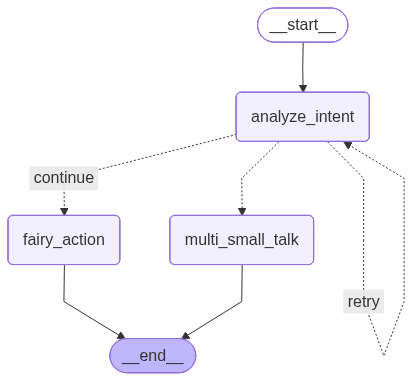

In [17]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

from agents.fairy.fairy_dungeon_agent import graph_builder as dungeon_graph_builder
dungeon_graph = dungeon_graph_builder.compile() 
dungeon_graph


In [18]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from agents.fairy.util import add_human_message
from core.game_dto.z_muck_factory import MockFactory
mock_player = MockFactory.create_dungeon_player(1)
memory = MemorySaver()
graph = dungeon_graph_builder.compile(memory)

config = {"configurable": {"thread_id": "user_1"}}
inputs = {
    "messages": [add_human_message(content="나 체력 몇이야?")],
    "dungenon_player": mock_player
}
result = await graph.ainvoke(inputs,config=config)

질문 나 체력 몇이야?
의도 포함 True
체크 메모리 False
멀티턴 False
2


In [19]:
result['messages']

[HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-12-03T19:32:12.088524'}, response_metadata={}, id='ae72e9d6-fcb0-4cf5-bae1-1b952a42dc5d'),
 AIMessage(content='현재 히로인의 체력은 472야!', additional_kwargs={'created_at': '2025-12-03T19:32:13.783420', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='1500070b-0e2b-4fcb-afcd-2485bf22bff0')]

In [20]:
await graph.ainvoke(
    { "messages": HumanMessage(content="테스트") },
    config=config
)

질문 테스트


{'messages': [HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-12-03T19:32:12.088524'}, response_metadata={}, id='ae72e9d6-fcb0-4cf5-bae1-1b952a42dc5d'),
  AIMessage(content='현재 히로인의 체력은 472야!', additional_kwargs={'created_at': '2025-12-03T19:32:13.783420', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='1500070b-0e2b-4fcb-afcd-2485bf22bff0'),
  HumanMessage(content='테스트', additional_kwargs={}, response_metadata={}, id='188bc5a2-f0f1-48af-9aca-c8a1749a0e1f')],
 'intent_types': [<FairyDungeonIntentType.SMALLTALK: 'SMALLTALK'>],
 'dungenon_player': DungeonPlayerData(playerId=1, affection=1, heroineId=2, sanity=54, scenarioLevel=2, difficulty=1, stats=StatData(hp=472, moveSpeed=1.17, cooldownReduction=1.63, strength=16, dexterity=18, intelligence=None, critChance=23.68, skillDamageMultiplier=2.38, autoAttackMultiplier=2.13, attackSpeed=2.21), skills=SkillData(passiveSkillId=4, passiveSkillLevel=2, activeSkillId=7, activeSkillLevel=1), weapon=WeaponData(we

In [21]:
from agents.fairy.util import get_small_talk_history
get_small_talk_history(result["messages"])

[HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-12-03T19:32:12.088524'}, response_metadata={}, id='ae72e9d6-fcb0-4cf5-bae1-1b952a42dc5d'),
 AIMessage(content='현재 히로인의 체력은 472야!', additional_kwargs={'created_at': '2025-12-03T19:32:13.783420', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='1500070b-0e2b-4fcb-afcd-2485bf22bff0')]

In [22]:
result = await graph.ainvoke(
    { "messages": add_human_message(content="나 체력 몇이라고 했었지?") },
    config=config
)

질문 나 체력 몇이라고 했었지?
의도 포함 True
체크 메모리 True
멀티턴 True
아래의 멀티턴 True


In [23]:
from agents.fairy.util import get_small_talk_history
get_small_talk_history(result["messages"])

[HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-12-03T19:32:12.088524'}, response_metadata={}, id='ae72e9d6-fcb0-4cf5-bae1-1b952a42dc5d'),
 AIMessage(content='현재 히로인의 체력은 472야!', additional_kwargs={'created_at': '2025-12-03T19:32:13.783420', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='1500070b-0e2b-4fcb-afcd-2485bf22bff0'),
 HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-03T19:32:14.087949'}, response_metadata={}, id='772e6d15-03a8-4472-8f39-967152319a7a'),
 AIMessage(content='체력 472면 아직 버틸 만하지만, 던전 깊숙이니 방심은 금물이야. 회복 아이템 있으면 아끼지 말고 써! 다음 전투 준비는 됐어?', additional_kwargs={'created_at': '2025-12-03T19:32:16.344019', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='58679a03-e10d-4d75-8a05-b99e815521f7')]

In [24]:
await graph.ainvoke(
    { "messages": add_human_message(content="물약 사용해") },
    config=config
)

질문 물약 사용해
의도 포함 False
체크 메모리 False
멀티턴 False
2


{'messages': [HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-12-03T19:32:12.088524'}, response_metadata={}, id='ae72e9d6-fcb0-4cf5-bae1-1b952a42dc5d'),
  AIMessage(content='현재 히로인의 체력은 472야!', additional_kwargs={'created_at': '2025-12-03T19:32:13.783420', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='1500070b-0e2b-4fcb-afcd-2485bf22bff0'),
  HumanMessage(content='테스트', additional_kwargs={}, response_metadata={}, id='188bc5a2-f0f1-48af-9aca-c8a1749a0e1f'),
  HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-03T19:32:14.087949'}, response_metadata={}, id='772e6d15-03a8-4472-8f39-967152319a7a'),
  AIMessage(content='체력 472면 아직 버틸 만하지만, 던전 깊숙이니 방심은 금물이야. 회복 아이템 있으면 아끼지 말고 써! 다음 전투 준비는 됐어?', additional_kwargs={'created_at': '2025-12-03T19:32:16.344019', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='58679a03-e10d-4d75-8a05-b99e815521f7'),
  HumanMessage(content='물약 사용해', additional_kwargs={'created_at': '2025-12

In [25]:
result = await graph.ainvoke(
    { "messages": add_human_message(content="게임 조작키좀 알려줘") },
    config=config
)
result["messages"][-1]

질문 게임 조작키좀 알려줘
의도 포함 False
체크 메모리 False
멀티턴 False
2


AIMessage(content='게임 조작키는 다음과 같아요.\n\n- 앞으로 이동: W\n- 뒤로 이동: S\n- 왼쪽으로 이동: A\n- 오른쪽으로 이동: D\n- 기본 공격: 좌클릭\n- 회피: 우클릭 또는 스페이스바\n- 달리기: Shift\n- 타게팅: Q\n- 무기 스킬: E\n- 직업 고유 스킬/킷: R\n- 상호작용: F\n- 인벤토리: Tab\n\n이 조작키들을 사용해서 게임을 즐기세요!', additional_kwargs={'created_at': '2025-12-03T19:32:18.771694', 'intent_types': ['GAME_SYSTEM_INFO']}, response_metadata={}, id='25ae53dc-6194-447e-937b-dce3d7aaf53e')

In [26]:
print(result["messages"][-1].content)

게임 조작키는 다음과 같아요.

- 앞으로 이동: W
- 뒤로 이동: S
- 왼쪽으로 이동: A
- 오른쪽으로 이동: D
- 기본 공격: 좌클릭
- 회피: 우클릭 또는 스페이스바
- 달리기: Shift
- 타게팅: Q
- 무기 스킬: E
- 직업 고유 스킬/킷: R
- 상호작용: F
- 인벤토리: Tab

이 조작키들을 사용해서 게임을 즐기세요!


# 몬스터 공략 (주로 보스몬스터 위주로)
 1. 현재방의 몬스터 상세 정보 필요 -> 상세정보 Search RAG (K = 1)
 2. 몬스터 찾기 멀티쿼리 필요 -> 사용자는 몬스터 명을 모를 확률이 큼 => 멀티쿼리로 현재방중 몬스터 특징에 따라 몬스터 찾기
 3. 몬스터 공략법 RAG 필요 -> 찾은 몬스터의 공략 해결책을 찾는 서칭 필요 

# 이벤트 공략 
 - 캐시 DB로부터 생성된 이벤트 정보 GET -> 힌트 위주로 제공 

# 던전 안내
 - 캐시 DB로 부터 생성된 던전의 전체 특징을 요약 후 브리핑 

# 인터렉션 
 - 방 불키기, 물약 사용, 아이템 사용 return 액션, 사용ID(Option)

# 멀티턴 전략 
 - 이전 대화 요약본 저장 
